# Table of Contents

1. [Data Processing](#data_processing)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#feature_engineering)
4. [Methodology](#methodology)
<br> 4.1 [Model 1: *Logistic Regression*](#model_1)
<br> 4.2 [Model 2: *Regression Tree*](#model_2)
<br> 4.3 [Model 3: *XG Boost*](#model_3)

_importing necessary libraries_

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import ast
from tqdm import tqdm
import multiprocessing
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt_tab')

In [81]:
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## <font color = '#e64626'><a id='data_processing'>1. Data Processing</a></font>

In [82]:
train = pd.read_csv(r'Data\train.csv')
test = pd.read_csv(r'Data\test.csv')

X_train = train.drop(columns=['price'])
y_train = train['price']

X_test = test

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12500 non-null  int64  
 1   price                        12500 non-null  int64  
 2   description                  12500 non-null  object 
 3   neighborhood_overview        12500 non-null  object 
 4   host_acceptance_rate         12500 non-null  float64
 5   neighbourhood                12500 non-null  object 
 6   latitude                     12500 non-null  float64
 7   longitude                    12500 non-null  float64
 8   property_type                12500 non-null  object 
 9   room_type                    12500 non-null  object 
 10  accommodates                 12500 non-null  int64  
 11  bedrooms                     12500 non-null  float64
 12  beds                         12498 non-null  float64
 13  amenities       

In [84]:
train.describe() # distribution of the data

,id,price,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,review_scores_cleanliness,review_scores_communication,review_scores_location
count,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.00000,12498.000000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000
mean,8749.500000,285.371520,0.917338,-34.290696,149.280542,4.610480,2.10432,2.731957,6.366320,575.79008,55.749520,4.745741,4.867890,4.866642
std,3608.583517,201.281559,0.174188,3.397141,3.599421,2.522646,1.20098,1.829188,23.493225,484.72756,81.130947,0.343597,0.272619,0.212139
min,2500.000000,19.000000,0.000000,-38.219124,144.518047,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
25%,5624.750000,153.000000,0.930000,-37.813902,144.990328,2.000000,1.00000,1.000000,2.000000,70.00000,7.000000,4.660000,4.860000,4.830000
50%,8749.500000,220.000000,0.990000,-33.889020,151.191841,4.000000,2.00000,2.000000,2.000000,365.00000,24.000000,4.850000,4.960000,4.920000
75%,11874.250000,346.000000,1.000000,-32.028900,152.540318,6.000000,3.00000,4.000000,3.000000,1125.00000,71.000000,4.980000,5.000000,5.000000
max,14999.000000,1249.000000,1.000000,-28.165120,153.636110,16.000000,35.00000,31.000000,999.000000,1162.00000,1013.000000,5.000000,5.000000,5.000000


In [85]:
X_train.head() # first 5 rows of the data

,id,description,neighborhood_overview,host_acceptance_rate,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,number_of_reviews,review_scores_cleanliness,review_scores_communication,review_scores_location
0,2500,"Secluded, self-contained studio apartment just...",Friendly neighbourhood with easy access to Man...,0.67,Manly,-33.793440,151.280990,Entire guesthouse,Entire home/apt,2,1.0,1.0,"[""Hangers"", ""Security cameras on property"", ""A...",4,1125,3,5.00,4.33,5.00
1,2501,"Located in a heritage-listed apartment block, ...",This impressive property on the city fringe is...,0.98,Yarra,-37.798788,145.000433,Entire rental unit,Entire home/apt,2,1.0,3.0,"[""Hot water kettle"", ""Hot water"", ""Dining tabl...",5,1125,2,3.50,3.50,4.50
2,2502,Looking for a peaceful place in paradise? Heal...,"Located a short drive to Nana Glen village, we...",0.88,Coffs Harbour,-30.154650,153.019150,Entire guesthouse,Entire home/apt,3,2.0,2.0,"[""Cooking basics"", ""TV"", ""Portable heater"", ""S...",2,1125,29,4.90,4.86,4.86
3,2503,Melbourne City Retreat. Best Location in the H...,Melbourne Central · Victoria Market · Emporium...,1.00,Melbourne,-37.807930,144.961110,Entire rental unit,Entire home/apt,6,2.0,4.0,"[""Microwave"", ""Hot water kettle"", ""Drying rack...",1,1125,290,4.76,4.89,4.91
4,2504,"This relaxing, spacious, beach side 1 bedroom ...",The property is located in the hip heart of Bo...,0.99,Waverley,-33.890310,151.270760,Entire rental unit,Entire home/apt,2,1.0,1.0,"[""Toaster"", ""Hangers"", ""Central air conditioni...",2,90,25,4.40,4.84,4.88


In [86]:
X_train.shape, X_test.shape

((12500, 19), (2500, 19))

In [87]:
missing_values_train = X_train.isnull().sum()
missing_values_test = X_test.isnull().sum()

In [88]:
missing_values_train

id                             0
description                    0
neighborhood_overview          0
host_acceptance_rate           0
neighbourhood                  0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bedrooms                       0
beds                           2
amenities                      0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
review_scores_cleanliness      0
review_scores_communication    0
review_scores_location         0
dtype: int64

In [89]:
X_train['beds'].fillna(X_train['beds'].mean(), inplace=True) # since there are 2 missing values for this feature, we can replace them with the mean value

In [90]:
len(X_train['property_type'].unique()), len(X_test['property_type'].unique()) 
# a quick look at the data in excel showed that there is different number of unique values for same feature in train and test, will deal with this later

(63, 48)

## <font color = '#e64626'><a id='eda'>2. Exploratory Data Analysis</a></font>

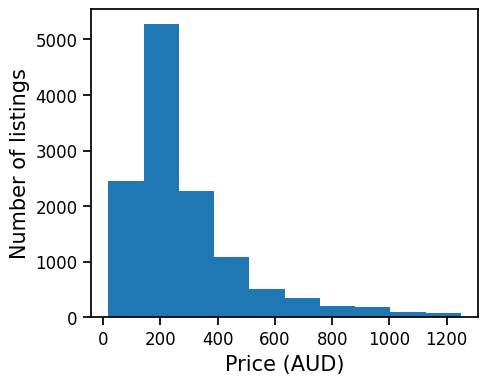

In [91]:
plt.figure(figsize=(5, 4))
plt.hist(y_train, bins=10);
plt.xlabel('Price (AUD)')
plt.ylabel('Number of listings')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')

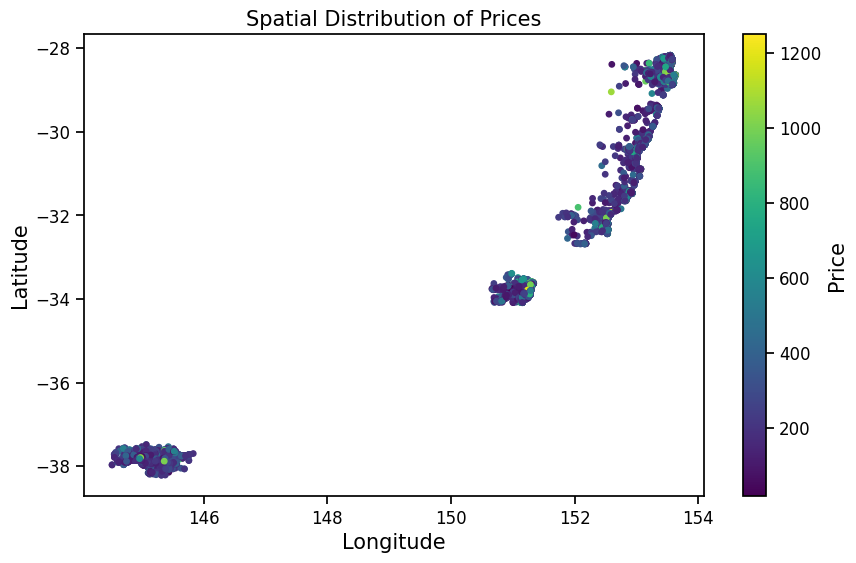

<Figure size 640x480 with 0 Axes>

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train['longitude'], X_train['latitude'], c=y_train, cmap='viridis', s=15)
plt.title('Spatial Distribution of Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Price')
plt.show()
plt.savefig('spatial_distribution.png', dpi=300, bbox_inches='tight')


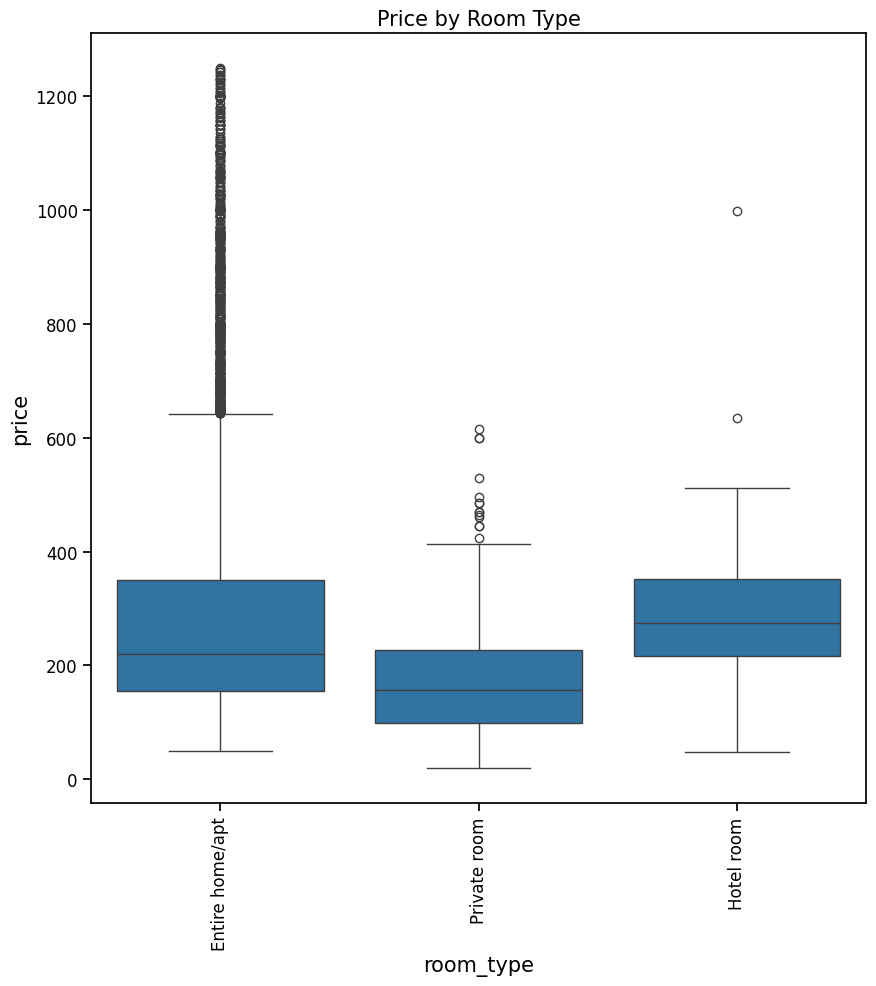

In [93]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='room_type', y='price', data=train)
plt.xticks(rotation=90)
plt.title('Price by Room Type')
plt.savefig('room_tpye_boxplot.png', dpi=300, bbox_inches='tight')


## <font color = '#e64626'><a id='feature_engineering'>3. Feature Engineering</a></font>

_Label Encoding_: convert categorical data into numerical format so that machine learning algorithms (which mostly work with numerical data) can process it

In [94]:
label_encoder = LabelEncoder()

# fit the label encoder on the combined list of property_type values from both training and test datasets
combined_property = list(X_train['property_type'].values) + list(X_test['property_type'].values)
label_encoder.fit(combined_property)

# transform the 'property_type' feature in both training and test datasets
X_train['property_type_encoded'] = label_encoder.transform(X_train['property_type'])
X_test['property_type_encoded'] = label_encoder.transform(X_test['property_type'])

# get dummy values for room_type
X_train = pd.get_dummies(X_train, columns=['room_type'], prefix=['room'])
X_test = pd.get_dummies(X_test, columns=['room_type'], prefix=['room'])



In [95]:
# select the review-related attributes
review_attributes = ['review_scores_cleanliness', 'review_scores_communication', 'review_scores_location']

# create the composite review score feature
X_train['Composite_review_score'] = X_train[review_attributes].mean(axis=1)
X_test['Composite_review_score'] = X_test[review_attributes].mean(axis=1)



_Tokenising_: break text data into smaller chunks (words, phrases, or tokens) to make it easier to process. I used Word2Vec to generate embeddings, which represent words as dense vectors in a continuous vector space.

In [96]:
# tokenize description and neighborhood_overview
X_train['description_tokens'] = X_train['description'].apply(lambda text: text.split())
X_train['neighborhood_tokens'] = X_train['neighborhood_overview'].apply(lambda text: text.split())

X_test['description_tokens'] = X_test['description'].apply(lambda text: text.split())
X_test['neighborhood_tokens'] = X_test['neighborhood_overview'].apply(lambda text: text.split())

X_train['amenities'] = X_train['amenities'].apply(lambda amenities_str: ast.literal_eval(amenities_str) if isinstance(amenities_str, str) else []) # Convert amenities from string to list
X_train['amenities_tokens'] = X_train['amenities'].apply(lambda amenities_list: [word for item in amenities_list for word in item.split()]) # Tokenize the individual amenities

# doing the same for test set
X_test['amenities'] = X_test['amenities'].apply(lambda amenities_str: ast.literal_eval(amenities_str) if isinstance(amenities_str, str) else [])
X_test['amenities_tokens'] = X_test['amenities'].apply(lambda amenities_list: [word for item in amenities_list for word in item.split()])

In [97]:
# join the token lists into strings
X_train['description_text'] = X_train['description_tokens'].apply(lambda tokens: ' '.join(tokens))
X_train['neighborhood_text'] = X_train['neighborhood_tokens'].apply(lambda tokens: ' '.join(tokens))
X_train['amenities_text'] = X_train['amenities_tokens'].apply(lambda tokens: ' '.join(tokens))

# concatenate the text features
X_train['combined_text'] = X_train['description_text'] + ' ' + X_train['neighborhood_text'] + ' ' + X_train['amenities_text']

# doing the same for test dataset
X_test['description_text'] = X_test['description_tokens'].apply(lambda tokens: ' '.join(tokens))
X_test['neighborhood_text'] = X_test['neighborhood_tokens'].apply(lambda tokens: ' '.join(tokens))
X_test['amenities_text'] = X_test['amenities_tokens'].apply(lambda tokens: ' '.join(tokens))

X_test['combined_text'] = X_test['description_text'] + ' ' + X_test['neighborhood_text'] + ' ' + X_test['amenities_text']

In [98]:
X_train['tokens'] = X_train['combined_text'].apply(lambda text: word_tokenize(text))
X_test['tokens'] = X_test['combined_text'].apply(lambda text: word_tokenize(text))

In [99]:
cores = multiprocessing.cpu_count()

sentences_train = X_train['tokens'].tolist()
textmodel_train = Word2Vec(sentences_train, vector_size=100, window=2, min_count=1, sg=1, workers=cores-1)

sentences_test = X_test['tokens'].tolist()
textmodel_test = Word2Vec(sentences_test, vector_size=100, window=2, min_count=1, sg=1, workers=cores-1)

_Vectorising_: convert text data into numerical features based on word importance within a document and across the corpus.

In [100]:
tfidf_vectorizer = TfidfVectorizer() # initialize the TF-IDF vectorizer
vector_dim_N = 100
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['combined_text']) # fit and transform the 'combined_text' to compute TF-IDF scores
tfidf_matrix_test = tfidf_vectorizer.fit_transform(X_test['combined_text'])

feature_names = tfidf_vectorizer.get_feature_names_out() # get the feature names (words) from the vectorizer

tfidf_array_train = tfidf_matrix_train.toarray() # convert the TF-IDF matrix to an array
tfidf_array_test = tfidf_matrix_test.toarray()

def weighted_sum_text(X_data, textmodelwv):
    weighted_sum_text_train = [] # initialize an array to store the weighted sum vectors

    stored_words_train = {}

    # iterate through each listing in the dataset
    for i, text in enumerate(tqdm(X_data['combined_text'])):
        words = text.split()
        weighted_sum_vector = np.zeros(vector_dim_N)

        for j, word in enumerate(words):
            if word not in stored_words_train:
                add_it = False
                if word in textmodelwv:
                    # get the column index corresponding to the word in the TF-IDF matrix
                    word_index = np.where(feature_names == word)[0]  # np.where to find the index
                    if len(word_index) > 0:
                        word_index = word_index[0]  # extract the index from the array
                        stored_words_train[word] = word_index     
                        add_it = True
                if not add_it:
                    stored_words_train[word] = -1
            if stored_words_train[word] != -1:
                word_index = stored_words_train[word]
                tfidf_score = tfidf_array_train[i, word_index] # get the TF-IDF score for the word in this listing
                weighted_sum_vector += tfidf_score * textmodelwv[word] # weight the word's embedding and add it to the vector

        weighted_sum_text_train.append(weighted_sum_vector)
    return weighted_sum_text_train

weighted_sum_text_train = weighted_sum_text(X_train, textmodel_train.wv)
weighted_sum_text_test = weighted_sum_text(X_test, textmodel_test.wv)

X_train['weighted_sum_text'] = weighted_sum_text_train # add the weighted sum vectors as a new feature
X_test['weighted_sum_text'] = weighted_sum_text_test

100%|██████████| 2500/2500 [00:12<00:00, 201.98it/s]


In [101]:
# concatenate the new dataframe with the original dataframe

weighted_sum_df_train = pd.DataFrame(X_train['weighted_sum_text'].tolist(), columns=[f'weighted_sum_dim_{i}' for i in range(100)]) 
X_train = pd.concat([X_train, weighted_sum_df_train], axis=1) 
X_train = X_train.drop(columns=['weighted_sum_text'])

# doing the same for test dataset
weighted_sum_df_test = pd.DataFrame(X_test['weighted_sum_text'].tolist(), columns=[f'weighted_sum_dim_{i}' for i in range(100)])
X_test = pd.concat([X_test, weighted_sum_df_test], axis=1)
X_test = X_test.drop(columns=['weighted_sum_text'])

In [102]:
# dropping redundant columns after feature processing 
X_train = X_train.drop(columns=['property_type' ,'neighbourhood', 'description', 'neighborhood_overview', 'amenities', 'description_tokens', 'neighborhood_tokens', 'amenities_tokens', 'description_text', 'neighborhood_text', 'amenities_text', 'combined_text', 'tokens', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location'])

X_test = X_test.drop(columns=['property_type', 'neighbourhood', 'description', 'neighborhood_overview', 'amenities', 'description_tokens', 'neighborhood_tokens', 'amenities_tokens', 'description_text', 'neighborhood_text', 'amenities_text', 'combined_text', 'tokens', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location'])

_Splitting and Scaling_ 

In [103]:
X_train_original = X_train
y_train_original = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

scaler = StandardScaler()

scaler.fit(X_train_original)
X_train_original_scaled = scaler.transform(X_train_original)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [104]:
X_train.shape, X_test.shape

((10000, 115), (2500, 115))

## <font color = '#e64626'><a id='methodology'>4. Methodology</a></font>

### <font color = '#e64626'><a id='model_1'>4.1. Model 1: *Lasso Regression*</a></font>
(simple, interpretable algorithm)

In [105]:
# initialize LassoCV to find the optimal alpha
lasso_cv = LassoCV(cv=10) 
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_

# use the best alpha to create the final Lasso model
lasso_model = Lasso(alpha=best_alpha, max_iter=200)
lasso_model.fit(X_train_scaled, y_train)

# make predictions using the final Lasso model
y_pred_val = lasso_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

print("Best alpha from LassoCV:", round(best_alpha, 2))
print("Validation RMSE:", round(rmse, 2))
print("Validation R-squared:", round(r2, 2))


Best alpha from LassoCV: 1.23
Validation RMSE: 150.5
Validation R-squared: 0.42


In [106]:
# generate test predictions if X_test_scaled is available
if 'X_test_scaled' in locals():
    y_pred_test = lasso_model.predict(X_test_scaled)
    print("Test predictions generated for X_test_scaled.")

    # Note: Metrics cannot be computed as y_test is unavailable coz this project was a part of a competition and y_test was kept hidden for evaluation
    print("Metrics for the test set cannot be calculated because y_test is not provided.")
else:
    print("No test set (X_test_scaled) provided. Skipping test predictions.")


# Placeholder for IDs (if applicable)
# id_col = np.arange(len(y_pred)).reshape(-1, 1)


Test predictions generated for X_test_scaled.
Metrics for the test set cannot be calculated because y_test is not provided.


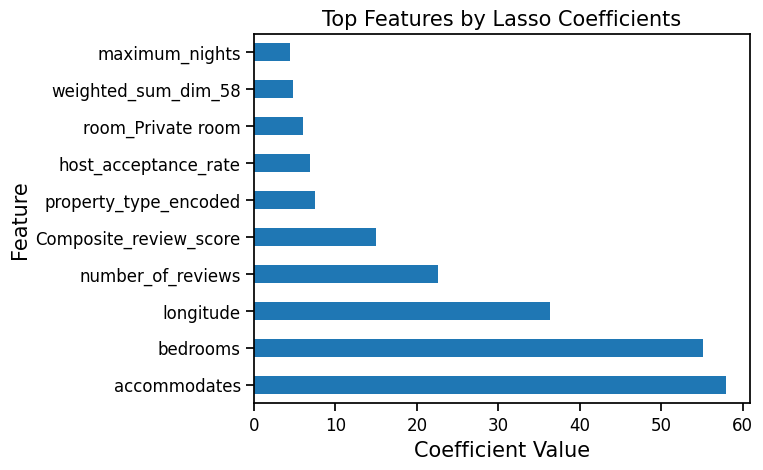

In [107]:
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
sorted_coefficients = lasso_coefficients.abs().sort_values(ascending=False)

top_features = sorted_coefficients.head(10)  # selecting the top 10 features to plot
top_features.plot(kind="barh")
plt.title("Top Features by Lasso Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()


### <font color = '#e64626'><a id='model_2'>4.2. Model 2: *Single Regression Tree*</a></font>
(interpretable and works well with non-linear relationships and feature interactions)

In [108]:
# initialize the DecisionTreeRegressor
reg_tree = DecisionTreeRegressor()

# grid search to find the best set of params
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [3, 5, 7],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(reg_tree, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=4)
grid_search.fit(X_train, y_train)

best_tree_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# predictions using the model on the validation dataset
y_pred_val = best_tree_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

print("Validation RMSE:", round(rmse, 2))
print("Validation R-squared:", round(r2, 2))


Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best hyperparameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 4}
Validation RMSE: 160.49
Validation R-squared: 0.34


In [109]:
# generate test predictions if X_test_scaled is available
if 'X_test_scaled' in locals():
    y_pred_test = best_tree_model.predict(X_test_scaled)
    print("Test predictions generated for X_test_scaled.")

    # Note: Metrics cannot be computed as y_test is unavailable coz this project was a part of a competition and y_test was kept hidden for evaluation
    print("Metrics for the test set cannot be calculated because y_test is not provided.")
else:
    print("No test set (X_test_scaled) provided. Skipping test predictions.")


# Placeholder for IDs (if applicable)
# id_col = np.arange(len(y_pred)).reshape(-1, 1)

Test predictions generated for X_test_scaled.
Metrics for the test set cannot be calculated because y_test is not provided.


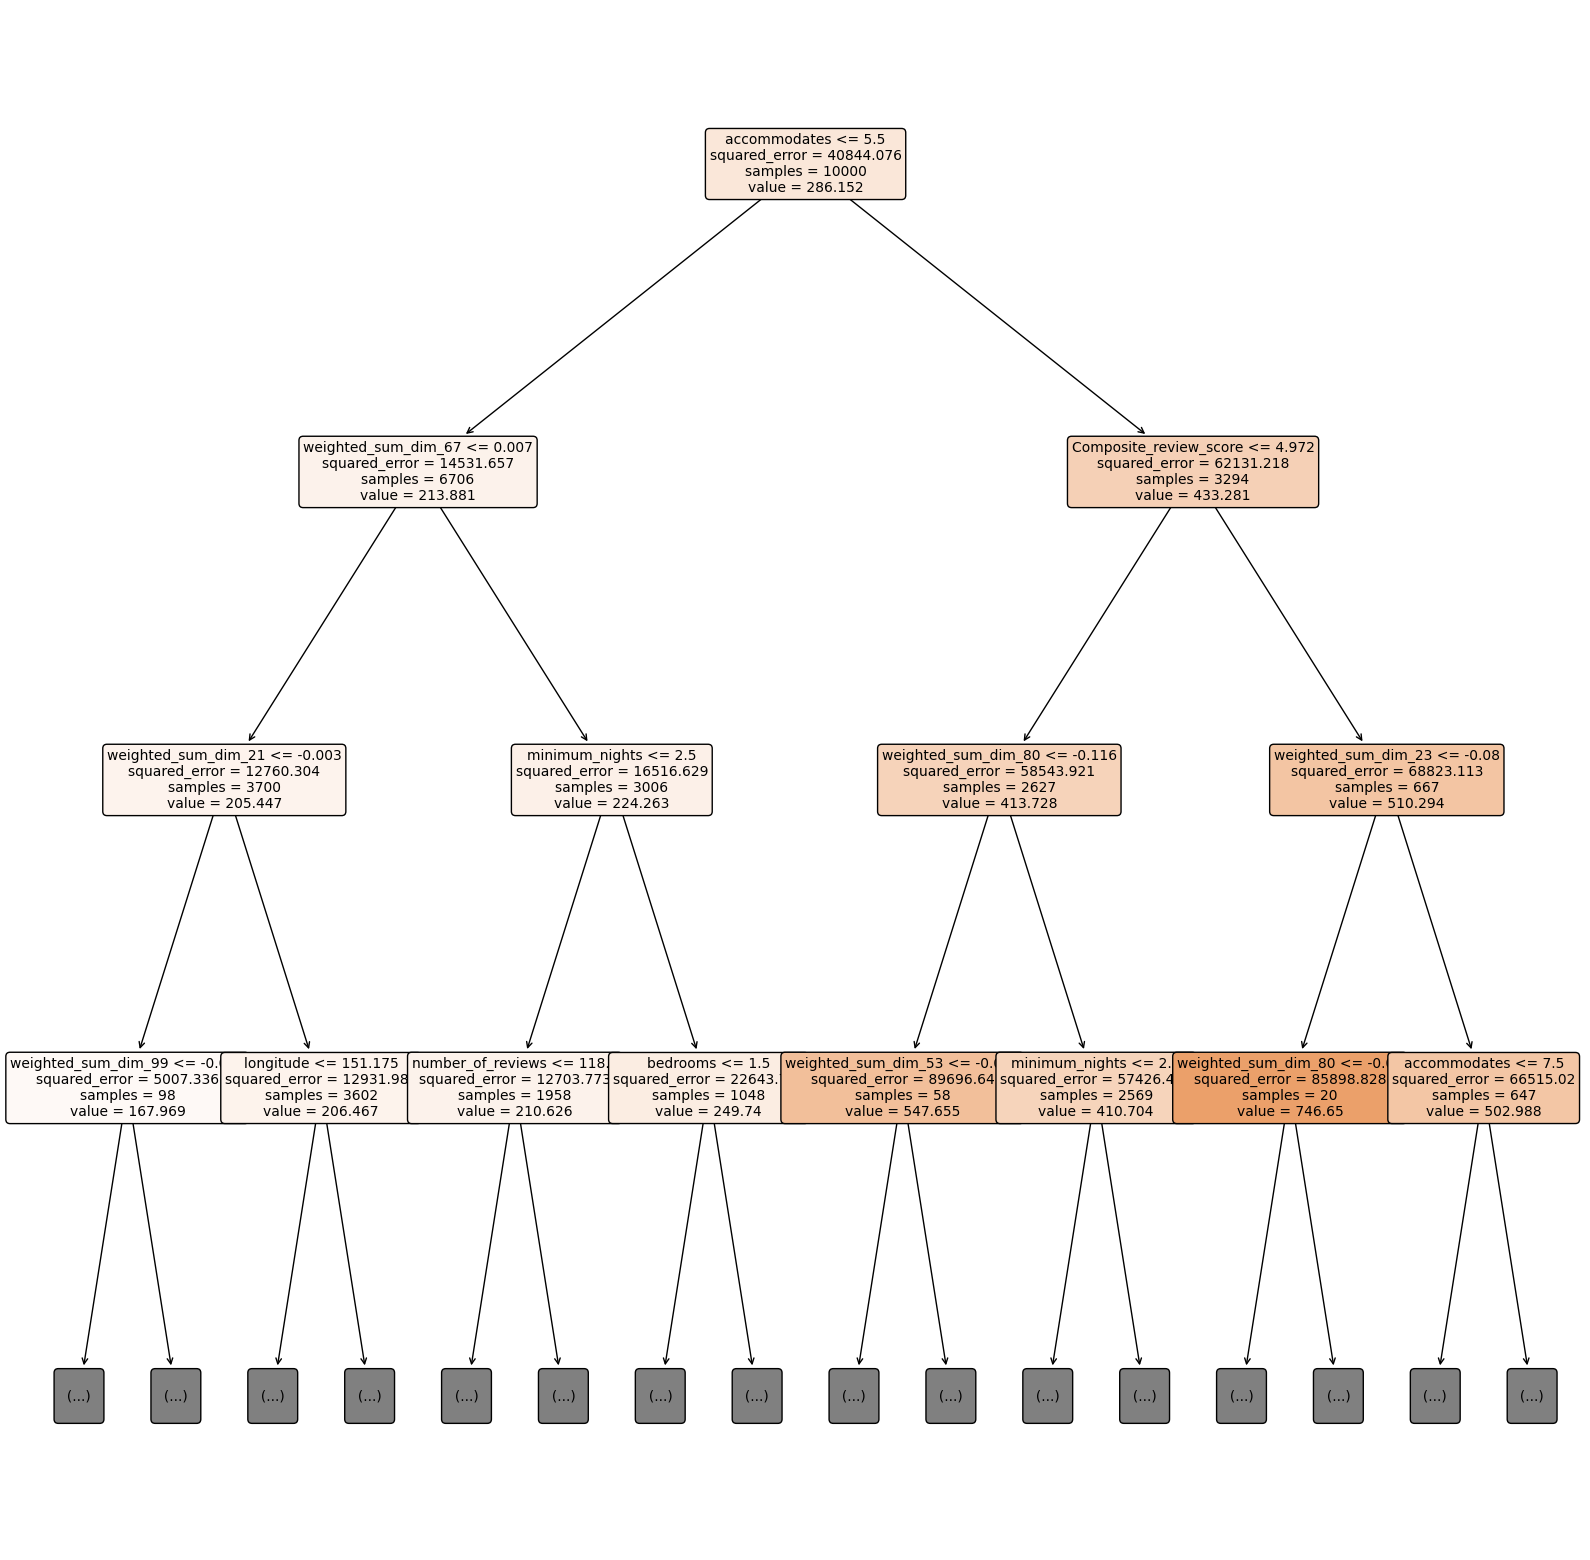

In [110]:
plt.figure(figsize=(20, 20))
plot_tree(best_tree_model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3, fontsize=10)
plt.show()


### <font color = '#e64626'><a id='model_3'>4.2. Model 3: *XG Boost*</a></font>
(high-performance, gradient-boosting algorithm that is widely used for structured/tabular data)

In [111]:
# initialize the XGBoost regressor
xgb_regressor = XGBRegressor()

param_grid = {
    'learning_rate': [0.1, 0.15, 0.2],  # Learning rate
    'n_estimators': [300, 400, 500],  # Number of trees
    'max_depth': [5, 10],  # Maximum depth of each tree
    'lambda': [5, 10, 15],  # L2 regularization term
    'alpha': [5, 10, 15]  # L1 regularization term 10
}

grid_search_xgb = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=4)

grid_search_xgb.fit(X_train_scaled, y_train)

# get the best hyperparameters from the search
best_params_xgb = grid_search_xgb.best_params_
best_xgb_model = grid_search_xgb.best_estimator_
print("Best hyperparameters:", best_params_xgb)

# predictions using the best model on the validation dataset
y_pred_val = best_xgb_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

print("Validation RMSE:", round(rmse, 2))
print("Validation R-squared:", round(r2, 2))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters: {'alpha': 15, 'lambda': 15, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
Validation RMSE: 125.01
Validation R-squared: 0.6


In [112]:
# generate test predictions if X_test_scaled is available
if 'X_test_scaled' in locals():
    y_pred_test = best_xgb_model.predict(X_test_scaled)
    print("Test predictions generated for X_test_scaled.")

    # Note: Metrics cannot be computed as y_test is unavailable coz this project was a part of a competition and y_test was kept hidden for evaluation
    print("Metrics for the test set cannot be calculated because y_test is not provided.")
else:
    print("No test set (X_test_scaled) provided. Skipping test predictions.")


# Placeholder for IDs (if applicable)
# id_col = np.arange(len(y_pred)).reshape(-1, 1)


Test predictions generated for X_test_scaled.
Metrics for the test set cannot be calculated because y_test is not provided.


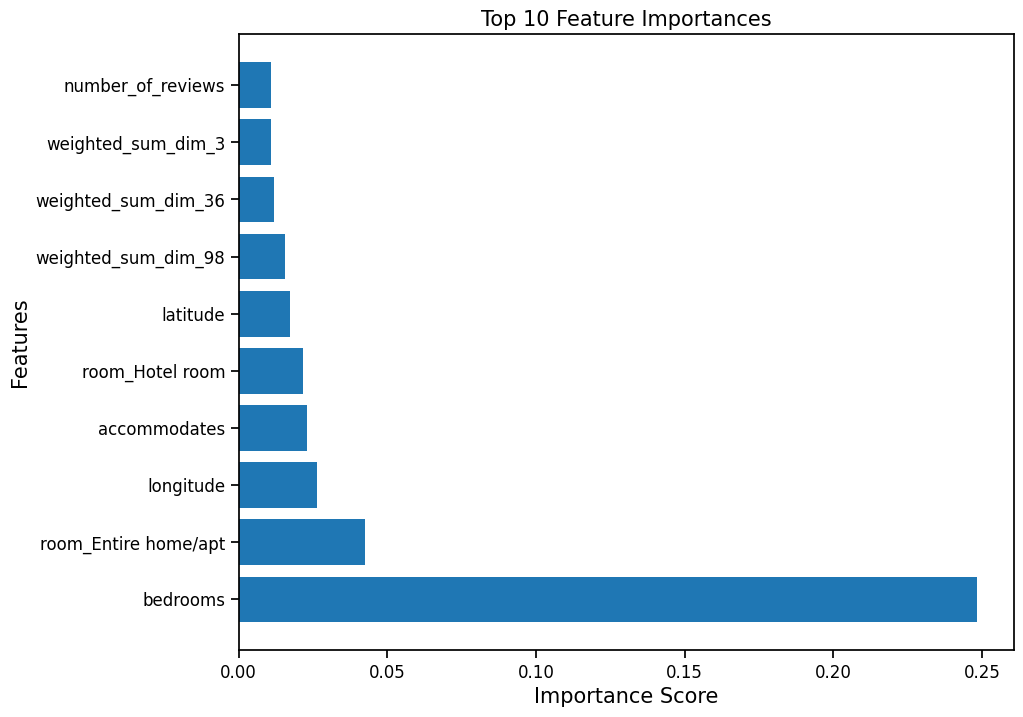

In [113]:
feature_importance = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.show()


Results

In [114]:
results = {
    'Model': ['Lasso Regression', 'Single Regression Tree', 'XGBoost'],
    'Training RMSE': [150.37, 142.7, 124.5], # retrieved from above model evaluation code blocks
    'Validation RMSE': [159.31, 145.41, 130.95]  # retrieved from Kaggle
}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Display the table
print(results_df)


                    Model  Training RMSE  Validation RMSE
0        Lasso Regression         150.37           159.31
1  Single Regression Tree         142.70           145.41
2                 XGBoost         124.50           130.95
